## Imports

In [296]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from glob import glob
from pandas.api.types import is_numeric_dtype
import seaborn as sns

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from typing import Dict, List
from tabulate import tabulate

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

from datetime import datetime
import time

from scipy.stats import f_oneway

import sqldf

import warnings
warnings.filterwarnings('ignore')

## Data Reading and Preparation

### Read Data

In [297]:
data_initial = pd.read_csv('test_data_clust.csv')

In [298]:
data_raw = data_initial.copy()

##### Normalization

In [300]:
from scipy.stats import norm, shapiro

def scaling_column(column):
    return (column - column.mean()) / column.std()

for col in tqdm(data_raw.columns):
    if is_numeric_dtype(data_raw[col]):
        shapiro_test = shapiro(data_raw[col])
        
        if shapiro_test.pvalue > 0.05:
            print(col)
            data_raw[col] = scaling_column(data_raw[col])
        else:
            data_raw[col] = scaling_column(np.log(data_raw[col] - data_raw[col].min() + 1))

  0%|          | 0/36 [00:00<?, ?it/s]

AvgOrderSumPurchased
AvgNumItemsOrderPurchased
RevenueClientPurchased
PurchasedItems
AvgMarginPurchased
ДЕТСКОЕ ПИТАНИЕ
ЖЕНСКИЕ ШТУЧКИ
КАНЦТОВАРЫ, КНИГИ, ДИСКИ
КОСМЕТИКА/ГИГИЕНА
ОБУВЬ
ПОДГУЗНИКИ
СОПУТСТВУЮЩИЕ ТОВАРЫ
ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА
ТОВАРЫ ДЛЯ ЖИВОТНЫХ
ТОВАРЫ ДЛЯ КОРМЛЕНИЯ
ИНОЕ
FAR EAST
NORTH
PRIVOLZIE
SIBERIA
SOUTHERN
URAL


In [301]:
mask = [not is_numeric_dtype(data_raw[c]) for c in data_raw.columns]
print(f'Founded {sum(mask)} non numeric elements')
data_raw.dtypes[mask]

Founded 1 non numeric elements


client_id    object
dtype: object

In [302]:
data_raw = data_raw.fillna(0)

In [303]:
cols_with_null = []
for col in data_raw.columns:
    null_count = (data_raw[col].isnull()).sum()
    if null_count != 0:
        print(f'{col}: {null_count}')
        cols_with_null.append(col)

In [304]:
data = data_raw.drop(cols_with_null, inplace=False, axis=1)
data.head(5)

,client_id,DistinctCountOrders,AverageNumItemsInOrder,RevenueClient,cnt_purchased_orders,AvgOrderSumPurchased,AvgNumItemsOrderPurchased,RevenueClientPurchased,PurchasedItems,AvgMarginPurchased,...,КГТ,ОДЕЖДА,ППКП,CENTRAL,FAR EAST,NORTH,PRIVOLZIE,SIBERIA,SOUTHERN,URAL
0,55575053-54505550565678,1.951586,-0.050848,1.47425,1.889269,-0.552987,-0.281517,2.195453,2.184868,-0.607808,...,1.759636,1.725272,-0.688958,0.831627,0.0,0.0,0.0,0.0,0.0,0.0
1,55575048-48524956565375,1.951586,0.489181,1.47425,1.889269,-1.072018,-0.042132,2.195453,2.184868,-0.692900,...,0.003671,0.700661,0.497352,-1.204233,0.0,0.0,0.0,0.0,0.0,0.0
2,55575555-57524953505673,1.951586,0.070241,1.47425,1.889269,-0.934347,-0.117748,2.195453,2.184868,-0.759326,...,-0.579645,1.882349,-0.747499,0.831627,0.0,0.0,0.0,0.0,0.0,0.0
3,55574953-50505150484978,1.951586,0.613335,1.47425,1.889269,0.272539,-0.302544,2.195453,2.184868,-0.258357,...,1.759636,1.519565,-0.433776,0.831627,0.0,0.0,0.0,0.0,0.0,0.0
4,55575054-51515151484875,1.951586,-0.441294,1.47425,1.889269,0.007245,-0.473591,2.195453,2.184868,-0.387509,...,1.759636,0.996064,-0.485987,0.831627,0.0,0.0,0.0,0.0,0.0,0.0


## Methods Performance

In [305]:
# take a small part of data for Spectral and Hierarchical Clustering as it timeouts with the larger datasets
n = 2048 #len(data)
X = data.sample(n).copy()
X.drop('client_id', axis=1, inplace=True)

In [306]:
len(X)

2048

In [307]:
X.head(5)

,DistinctCountOrders,AverageNumItemsInOrder,RevenueClient,cnt_purchased_orders,AvgOrderSumPurchased,AvgNumItemsOrderPurchased,RevenueClientPurchased,PurchasedItems,AvgMarginPurchased,SharePurchasedOrders,...,КГТ,ОДЕЖДА,ППКП,CENTRAL,FAR EAST,NORTH,PRIVOLZIE,SIBERIA,SOUTHERN,URAL
160014,0.762009,0.196598,1.474250,-0.996384,0.000000,0.000000,0.000000,0.000000,0.000000,-0.996999,...,-0.579645,1.882349,-0.770368,0.831627,0.0,0.0,0.0,0.0,0.0,0.0
4922,1.623907,0.559798,-0.296790,1.889269,-1.012227,0.416015,-0.467513,1.591231,-0.714829,1.178810,...,-0.579645,-0.234794,0.396500,-1.204233,0.0,0.0,0.0,0.0,0.0,0.0
138210,0.762009,-0.959100,-1.134687,-0.996384,0.000000,0.000000,0.000000,0.000000,0.000000,-0.996999,...,-0.579645,1.882349,-0.770368,0.831627,0.0,0.0,0.0,0.0,0.0,0.0
33778,-0.711416,-0.959100,1.474250,0.600233,2.197929,-0.797084,2.195453,-0.783315,2.089251,1.178810,...,1.759636,-0.613540,-0.770368,0.831627,0.0,0.0,0.0,0.0,0.0,0.0
64970,-0.711416,0.196598,0.134457,0.600233,0.247417,0.011649,-0.070430,-0.308406,-0.653213,1.178810,...,-0.579645,-0.613540,1.551599,-1.204233,0.0,0.0,0.0,0.0,0.0,0.0


### PostProcessing utils: metrics functions

In [308]:
from sklearn import metrics
from termcolor import colored

blue_bold = lambda x: colored(f'{x}', 'blue', attrs=['bold'])
green_bold = lambda x: colored(f'{x}', 'green', attrs=['bold'])

def compute_metrics(X: pd.DataFrame, labels: List, print_metrics: bool = False) -> Dict:
    silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
    calinski_harabasz_score = metrics.calinski_harabasz_score(X, labels)
    davies_bouldin_score = metrics.davies_bouldin_score(X, labels)

    result = dict(
        silhouette_score = silhouette_score,
        calinski_harabasz_score = calinski_harabasz_score,
        davies_bouldin_score = davies_bouldin_score,
    )

    if print_metrics:
        keys = list(result.keys())
        keys.sort()

        headers = [blue_bold('metric'), green_bold('value')]
        table = [[blue_bold(k), f'{result[k]:0.3f}'] for k in keys]

        print(f'number of clusters: {max(labels) + 1}', end='\n\n')
        print(tabulate(table, headers))

    return result


def research(method, hyper_params, X, arange_number_of_clusters):

    result = []
    for number_of_clusters in tqdm(arange_number_of_clusters, desc = f'{method.__class__.__name__}'):

        hyper_params['n_clusters'] = number_of_clusters
        clustering = method(**hyper_params).fit(X)
        labels = clustering.labels_
        m = compute_metrics(X, labels, print_metrics=False)

        result.append(dict(
            metrics = m,
            number_of_clusters = number_of_clusters
            )
        )

    return result


def plot_metrics_from_n_clusters(result: Dict):

    metrics_names = list(result[0]['metrics'].keys())
    metrics_names.sort()

    fig, axs = plt.subplots(1, len(metrics_names), figsize=(5*len(metrics_names), 5))

    for i, m in enumerate(metrics_names):
        metric_from_n = [r['metrics'][m] for r in result]
        ns = [r['number_of_clusters'] for r in result]

        axs[i].plot(ns, metric_from_n, label=f'{m}')
        axs[i].grid()
        axs[i].legend(loc='best')

        axs[i].set_xlabel('number_of_clusters')

    plt.show()

### Spectral clustering

In [309]:
from sklearn.cluster import SpectralClustering

In [310]:
hyper_params = {
    'n_clusters' : 4,
    'assign_labels' : 'kmeans'
}

In [311]:
clustering = SpectralClustering(
    **hyper_params,
    random_state=0).fit(X)

labels = clustering.labels_

n_clusters_ = hyper_params['n_clusters']

In [312]:
m = compute_metrics(X, labels, print_metrics=True)

number of clusters: 4

metric                     value
-----------------------  -------
calinski_harabasz_score  270.409
davies_bouldin_score       1.97
silhouette_score           0.147


type:   0%|          | 0/3 [00:00<?, ?it/s]

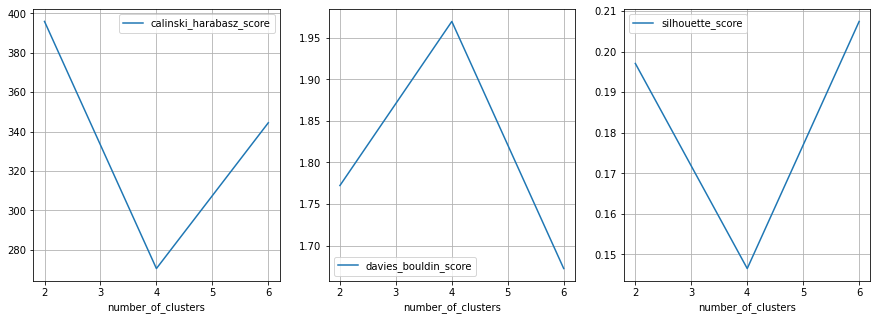

In [313]:
arange_number_of_clusters = [2, 4, 6]
metrics_from_n_clusters = research(SpectralClustering, hyper_params, X, arange_number_of_clusters)
plot_metrics_from_n_clusters(metrics_from_n_clusters)

### Hierarchical clustering

In [314]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [315]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [316]:
hyper_params = {
    'n_clusters' : 8,
    'linkage' : 'ward'
}

In [317]:
X = data.sample(n).copy()
X.drop('client_id', axis=1, inplace=True)

In [318]:
model = AgglomerativeClustering(distance_threshold= 0, n_clusters= None).fit(X)
labels = model.labels_
n_clusters_ = hyper_params['n_clusters']

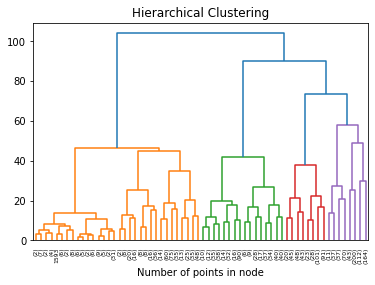

In [319]:
#plot
plt.title("Hierarchical Clustering")
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node")
plt.show()

In [320]:
# compute metrics

In [321]:
model = AgglomerativeClustering(**hyper_params).fit(X)
labels = model.labels_
n_clusters_ = hyper_params['n_clusters']

In [322]:
m = compute_metrics(X, labels, print_metrics=True)

number of clusters: 8

metric                     value
-----------------------  -------
calinski_harabasz_score  334.696
davies_bouldin_score       1.517
silhouette_score           0.23


type:   0%|          | 0/5 [00:00<?, ?it/s]

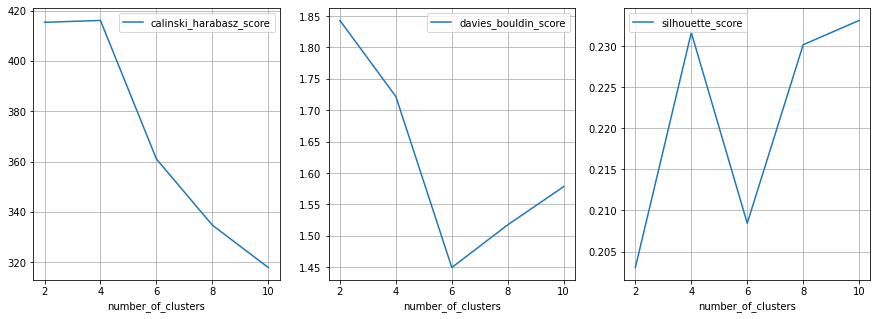

In [323]:
arange_number_of_clusters = [i for i in range(2, 12, 2)]
metrics_from_n_clusters = research(AgglomerativeClustering, hyper_params, X, arange_number_of_clusters)
plot_metrics_from_n_clusters(metrics_from_n_clusters)

## KMeans

In [324]:
X = data.copy()

id_col = 'client_id'

results = pd.DataFrame()
results['client_id'] = data[id_col]

X.drop('client_id', axis=1, inplace=True)

In [325]:
def optimal_number_cluster_kmeans(X, columns, max_number_cluster=10, title="elbow method"):
    ss = StandardScaler(with_std=False)
    sdf = ss.fit_transform(X)
    global distortions
    distortions = [] #sse
    for i in range(1, max_number_cluster):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=10, max_iter=300,
            tol=1e-04, random_state=0)
        km.fit(sdf)
        distortions.append(km.inertia_)
        
    kn = KneeLocator(range(1, max_number_cluster), distortions, curve='convex', direction='decreasing')
    k = kn.knee
    print('Optimal number of clusters: %d' % k)

  # plot
    plt.plot(range(1, max_number_cluster), distortions, marker='o')
    plt.title(title)
    plt.vlines(k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

Optimal number of clusters: 4


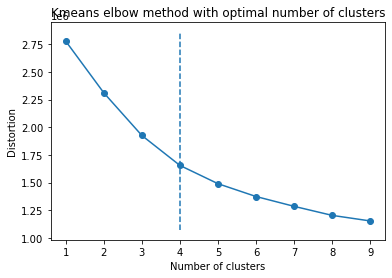

In [326]:
optimal_number_cluster_kmeans(X, X.columns, 10, "Kmeans elbow method with optimal number of clusters")

In [327]:
# kmeans
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
results['Cluster'] = kmeans.labels_

In [328]:
labels = kmeans.labels_

In [329]:
print(results['Cluster'].value_counts().sort_values())

0    41381
1    42044
2    42413
3    51505
Name: Cluster, dtype: int64


In [330]:
results

,client_id,Cluster
0,55575053-54505550565678,2
1,55575048-48524956565375,0
2,55575555-57524953505673,0
3,55574953-50505150484978,2
4,55575054-51515151484875,2
...,...,...
177338,55484848-48484848484870,1
177339,54545548-48484848484860,0
177340,52575355-48514856495345,1
177341,52535348-48484848484840,3


#### load the data for further usage

In [269]:
ress = data.merge(results, on = 'client_id')

In [332]:
ress = ress.fillna(0)

In [333]:
ress.to_csv('client_base.csv')

### Compute metrics

In [331]:
m = compute_metrics(X, labels, print_metrics=True)

number of clusters: 4

metric                       value
-----------------------  ---------
calinski_harabasz_score  40017.4
davies_bouldin_score         1.606
silhouette_score             0.257


In [270]:
grouped = results.groupby("Cluster").count()

In [271]:
# Plot the pie chart
fig = px.pie(grouped, values='client_id', names=grouped.index, title='Count of Client IDs by Cluster')
fig.show()

### Clusters weights

In [334]:
# Get weight of each feature for each cluster
cluster_weights = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
cluster_weights.index.name = 'Cluster'

In [335]:
# Calculate feature weights for each cluster
cluster_weights = pd.DataFrame(np.zeros((len(kmeans.cluster_centers_), X.shape[1])), columns=X.columns)
for i, centroid in enumerate(kmeans.cluster_centers_):
    # Calculate the relative weight of each feature for each cluster
    cluster_weights.iloc[i, :] = centroid / sum(centroid)

# Print results

cluster_weights

,DistinctCountOrders,AverageNumItemsInOrder,RevenueClient,cnt_purchased_orders,AvgOrderSumPurchased,AvgNumItemsOrderPurchased,RevenueClientPurchased,PurchasedItems,AvgMarginPurchased,SharePurchasedOrders,...,КГТ,ОДЕЖДА,ППКП,CENTRAL,FAR EAST,NORTH,PRIVOLZIE,SIBERIA,SOUTHERN,URAL
0,0.145031,0.224220,0.230453,-0.193163,-0.212894,0.039840,-0.096193,0.051260,0.082905,-0.298333,...,-1.089789,3.342490,-1.091375,0.177634,0.0,0.0,0.0,0.0,0.0,0.0
1,0.188976,0.171821,0.233854,0.040448,0.114107,0.076253,0.126995,0.103504,0.098645,-0.043467,...,0.287641,0.285386,0.348289,0.008744,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,0.014838,-0.125185,0.211412,0.026201,0.150854,-0.059519,0.147106,-0.043282,0.177516,0.020306,...,0.574822,-0.121149,-0.141098,-0.030585,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.167878,-0.397212,0.188569,-0.060292,0.084815,-0.202648,0.097209,-0.202028,0.249186,0.002939,...,0.425169,0.435089,-1.063977,-0.016232,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [336]:
cluster_weights.to_excel('cl_w.xlsx')

### Cluster main features

In [337]:
res = data_initial.merge(results, on ='client_id')

In [338]:
res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177343 entries, 0 to 177342
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   client_id                  177343 non-null  object 
 1   DistinctCountOrders        177343 non-null  float64
 2   AverageNumItemsInOrder     177343 non-null  float64
 3   RevenueClient              177343 non-null  float64
 4   cnt_purchased_orders       177343 non-null  float64
 5   AvgOrderSumPurchased       94150 non-null   float64
 6   AvgNumItemsOrderPurchased  94150 non-null   float64
 7   RevenueClientPurchased     94150 non-null   float64
 8   PurchasedItems             94150 non-null   float64
 9   AvgMarginPurchased         93895 non-null   float64
 10  SharePurchasedOrders       177343 non-null  float64
 11  ДЕТСКОЕ ПИТАНИЕ            177343 non-null  float64
 12  ЖЕНСКИЕ ШТУЧКИ             177343 non-null  float64
 13  ИГРУШКИ                    17

In [345]:
que = """
select 
    Cluster,
    avg(DistinctCountOrders) as avg_DistinctCountOrders,
    avg(AverageNumItemsInOrder) as avg_AverageNumItemsInOrder,
    avg(RevenueClient) as avg_RevenueClient,
    avg(PurchasedItems) as avg_PurchasedItems,
    avg(SharePurchasedOrders) as avg_SharePurchasedOrders,
    avg(AvgOrderSumPurchased) as avg_AvgOrderSumPurchased,
    avg("ДЕТСКОЕ ПИТАНИЕ") as avg_pers_child_food,
    avg("ЖЕНСКИЕ ШТУЧКИ") as avg_pers_female,
    avg("ИГРУШКИ") as avg_pers_toys,
    avg("КАНЦТОВАРЫ, КНИГИ, ДИСКИ") as avg_pers_office,
    avg("КОСМЕТИКА/ГИГИЕНА") as avg_pers_cosmetics,
    avg("КРУПНОГАБАРИТНЫЙ ТОВАР") as avg_pers_large,
    avg("ОБУВЬ") as avg_pers_shoes,
    avg("ПОДГУЗНИКИ") as avg_pers_pampers,
    avg("СОПУТСТВУЮЩИЕ ТОВАРЫ") as avg_pers_additional,
    avg("ТЕКСТИЛЬ, ТРИКОТАЖ") as avg_pers_textile,
    avg("ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА") as avg_pers_for_home,
    avg("ТОВАРЫ ДЛЯ ЖИВОТНЫХ") as avg_pers_for_animals,
    avg("ТОВАРЫ ДЛЯ КОРМЛЕНИЯ") as avg_pers_for_feeding
from res
group by 1
order by 1
"""
piv = sqldf.run(que)
piv

,Cluster,avg_pers_child_food,avg_pers_female,avg_pers_toys,avg_pers_office,avg_pers_cosmetics,avg_pers_large,avg_pers_shoes,avg_pers_pampers,avg_pers_additional,avg_pers_textile,avg_pers_for_home,avg_pers_for_animals,avg_pers_for_feeding
0,0,0.0,0.0,3037.251644,0.0,0.0,36.578861,0.0,0.0,0.0,2077.574340,0.0,0.0,0.0
1,1,0.0,0.0,37413.332520,0.0,0.0,4.496822,0.0,0.0,0.0,38.978119,0.0,0.0,0.0
2,2,0.0,0.0,3293.730774,0.0,0.0,2069.865625,0.0,0.0,0.0,395.067420,0.0,0.0,0.0
3,3,0.0,0.0,1903.280789,0.0,0.0,41.528955,0.0,0.0,0.0,238.924795,0.0,0.0,0.0


In [346]:
piv.to_excel('clust_desc_we.xlsx')

### TSNE

In [283]:
#import tsne
from sklearn.manifold import TSNE

In [284]:
df = data.copy()

In [285]:
df = df.merge(results, on = 'client_id')

In [287]:
df_corr = df[[col for col in df.select_dtypes(include='number').columns if df[col].nunique() > 2]]

In [288]:
#select only numeric columns with no missing values
X_tnse= df_corr.select_dtypes(include='number').dropna(axis=1)
#X_tnse = X_tnse[:1000]

In [289]:
#tsne
tsne = TSNE(n_components=2, random_state=42)
tsne_representation = tsne.fit_transform(X_tnse)

In [290]:
colors = ['red', 'green', 'blue', 'yellow']

In [291]:
X_tnse['Cluster'] = df['Cluster']

In [293]:
#pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca_representation = pca.fit_transform(X_tnse.select_dtypes(include='number').dropna(axis=1))

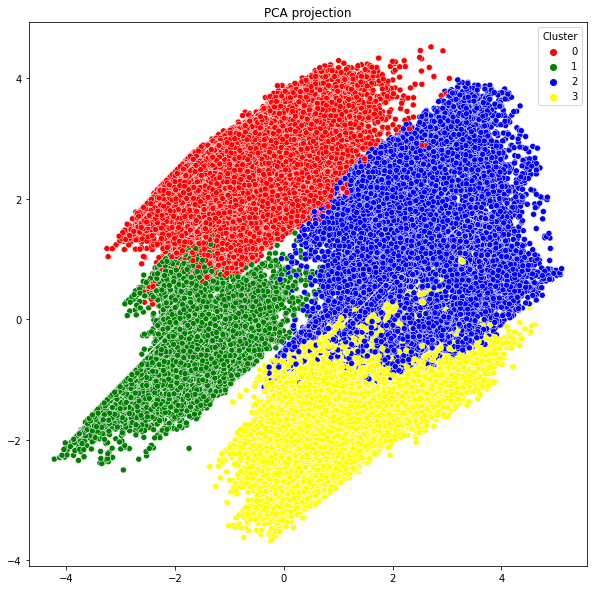

In [294]:
#plot
ax, fig = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=pca_representation[:, 0], y=pca_representation[:, 1], hue=X_tnse['Cluster'], palette = colors)
plt.title('PCA projection')
#plt.legend(colors.keys(), loc='upper right', title='Cluster')
plt.show()